# **Imports, installings and mount**

In [ ]:
! nvidia-smi
device='cuda'

Tue Sep  5 10:22:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.7 MB/s eta 0:00:00


In [ ]:
!pip install pytorch-lightning



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 10.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

import json
import csv
from pprint import pprint
import random
import numpy as np
import pandas as pd

import gensim.downloader
from gensim.models import KeyedVectors

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from tqdm.notebook import tqdm

from pathlib import Path
from typing import Any, Tuple
from typing import Dict, Iterator, List, Union, Optional
import os

import gensim.downloader
from gensim.models import KeyedVectors

import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from copy import deepcopy

from typing import Dict

from transformers import AutoTokenizer, BertTokenizer
from transformers import RobertaTokenizer, RobertaModel
from transformers import BertModel
from torchmetrics import Accuracy
from torch.optim import Adam

SEED = 1453

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from pytorch_lightning.callbacks import EarlyStopping
import pickle
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import torchmetrics

import torch.nn.functional as F

In [ ]:
SEED: int = 42

pl.seed_everything(SEED)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

#**Data paths**

**coarse grained**

In [ ]:
coarse_train_path = '/content/drive/MyDrive/Colab Notebooks/NLP/perhw2_agosto/data/coarse-grained/train_coarse_grained.json'
coarse_dev_path= '/content/drive/MyDrive/Colab Notebooks/NLP/perhw2_agosto/data/coarse-grained/val_coarse_grained.json'
coarse_test_path = '/content/drive/MyDrive/Colab Notebooks/NLP/perhw2_agosto/data/coarse-grained/test_coarse_grained.json'

**fine grained**

In [ ]:
fine_train_path = '/content/drive/MyDrive/Colab Notebooks/NLP/perhw2_agosto/data/fine-grained/train_fine_grained.json'
fine_dev_path= '/content/drive/MyDrive/Colab Notebooks/NLP/perhw2_agosto/data/fine-grained/val_fine_grained.json'
fine_test_path = '/content/drive/MyDrive/Colab Notebooks/NLP/perhw2_agosto/data/fine-grained/test_fine_grained.json'

#**Dataset**

in this section the dataset is created from the data in the json file
each element is

In [ ]:
class WSDDataset(Dataset):
  """ Attributes
    coarse_file_path and fine_file_path are the paths to the coarse/fine file in json,
    is_train is a boolean, if true the dataset will be built for training, else for validation/test
    MAX_LEN is an int that indicates the maximum lenght that each sentence must have for the tokenization
    train_candidate_vocab is a dictionary that contains the mapping candidate : int and is not none only if is_train is false
    coarse_or_fine is a boolean that indicates on what data should the dataset be build
    train_pos_vocab is a dictionary that contains the mapping int: pos_tag and is not none only if is_train is false
    num_candidates is not 0 only if is_train is false, it means
    tok is a string that denotes the chosen transformer, if it is bert then the tokenizer will be the Bert's one, otherwise the RoBERTa's one
    use_lemmas is a boolean and if True then the lemmas will be considered instead of the words
  """
  def __init__(self,
            coarse_file_path,
            fine_file_path,
            is_train,
            MAX_LEN,
            train_candidate_vocab = None,
            coarse_or_fine='coarse',
            train_pos_vocab = None,
            num_candidates = 0,
               tok='bert',
               use_lemmas = False):
    """
    initizialize the WSDDataset object,
    reads the content from the json file and preprocess it before adding it to data,if the number of words to disambiguate is greater than 1 ,
    then multiple examples are created for each target word out of the same sentence in order to have one target word for one sentence.
    The 'words' list of each element is preprocessed with the function 'preprocess_words' and some characters are replaced or eliminated.
    Two special characters are added around each target word in order to locate the start and the end of the word once the whole sentence is tokenized.
    also the list pos_tags and candidates are initialized, they will be used for creating the dictionaries candidate_vocab and pos_vocab if we are in training

    """
    self.coarse_or_fine = coarse_or_fine
    self.is_train = is_train
    self.data=[]
    self.MAX_LEN = MAX_LEN
    self.candidates = []
    self.candidate_vocab = {}
    self.train_candidate_vocab = train_candidate_vocab
    self.pos_tags = []
    self.pos_vocab = {}
    self.train_pos_vocab = train_pos_vocab
    self.num_candidates = num_candidates
    self.use_lemmas=use_lemmas
    if tok=='bert':
      self.tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
      self.tokenizer.add_tokens('[//START//]','[//END//]')
    else: ##roberta
      self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
      self.tokenizer.add_tokens('[//START//]','[//END//]')
    if self.coarse_or_fine == 'coarse':
      self.file_path = coarse_file_path
    else:
      self.file_path = fine_file_path

    with open(self.file_path, 'r') as file:
            data_json = json.load(file)
            for key, value in data_json.items():
              if len(value['instance_ids']) == 1:
                for elem in value['pos_tags']:
                    if elem not in self.pos_tags:
                      self.pos_tags.append(elem)
                if self.use_lemmas == True:

                    item = {
                        'instance_ids': value['instance_ids'],
                        'words':value['lemmas'],
                        'pos_tags': value['pos_tags'].copy(),
                        'senses': value['senses'],
                        'candidates': value['candidates'],
                    }
                else:

                    item = {
                        'instance_ids': value['instance_ids'],
                        'words':value['words'],
                        'pos_tags': value['pos_tags'].copy(),
                        'senses': value['senses'],
                        'candidates': value['candidates'],
                    }

                self.preprocess_words(item)
                pos = list(item['instance_ids'].keys())
                position = int(pos[0])
                temp = item['pos_tags'][position]
                item['pos_tags'].clear()


                item['pos_tags'] = []
                item['pos_tags'].append(temp)
                if len(item['words'])<(self.MAX_LEN-50):#####we want only sentences whose target word is not far away for computational reasons
                ##### also we subtract 50 beacuse the lenght of the sentence could be bigger after tokenization (some words get sub divided)
                  item['words'][position]='[//START//] '+ item['words'][position] + ' [//END//]'

                  self.candidates.append(value['candidates'])
                  self.data.append(item)
              elif len(value['instance_ids'])>1:
                for elem in list(value['instance_ids'].keys()):
                  new_value={}
                  new_value['instance_ids']={}
                  new_value['instance_ids'][elem]=value['instance_ids'][elem]
                  new_value['senses']={}
                  new_value['senses'][elem]=value['senses'][elem]
                  new_value['candidates']={}
                  new_value['candidates'][elem]=value['candidates'][elem]
                  new_value['lemmas']=value['lemmas'].copy()
                  new_value['words']=value['words'].copy()
                  new_value['pos_tags']=value['pos_tags'].copy()
                  for elem in new_value['pos_tags']:
                      if elem not in self.pos_tags:
                        self.pos_tags.append(elem)

                  if self.use_lemmas == False :
                      item = {
                        'instance_ids': new_value['instance_ids'],
                        'senses': new_value['senses'],
                        'candidates': new_value['candidates'],
                        'words':new_value['words'],
                        'pos_tags': new_value['pos_tags'],
                      }
                  else:
                    item = {
                        'instance_ids': new_value['instance_ids'],
                        'senses': new_value['senses'],
                        'candidates': new_value['candidates'],
                        'words':new_value['lemmas'],
                        'pos_tags': new_value['pos_tags'],
                      }
                  pos = list(item['instance_ids'].keys())

                  position = int(pos[0])
                  temp = item['pos_tags'][position]
                  item['pos_tags'].clear()
                  item['pos_tags'] = []
                  item['pos_tags'].append(temp)

                  self.preprocess_words(item)
                  ###we have to add flag tokens to indicate where is the position of the word
                  if len(item['words'])<(self.MAX_LEN-50):
                    ##### we want only sentences whose target word is not far away for computational reasons
                    ##### also we subtract 50 beacuse the lenght of the sentence could be bigger after tokenization (some words get sub divided)
                    item['words'][position]='[//START//] '+ item['words'][position] + ' [//END//]'

                    self.candidates.append(value['candidates'])
                    self.data.append(item)


            if is_train == True:

              self.candidate_vocab=self.create_candidate_vocab(self.candidates)
              self.pos_vocab=self.create_pos_vocab(self.pos_tags)
              self.num_candidates = len(self.candidate_vocab)

            else:
              self.candidate_vocab = self.train_candidate_vocab
              self.pos_vocab = self.train_pos_vocab
              self.num_candidates = self.num_candidates
  def preprocess_words(self,item):
    ##### function for preprocessing words, '[ ]' is changed with '( )' because it will be easier to get the position of the target word
    ##### since the preprocessing is done before adding the special tokens [START] and [END]
    for i in range(len(item['words'])):
      item['words'][i]=item['words'][i].lower()
      item['words'][i]=item['words'][i].replace(" ", "")
      item['words'][i]=item['words'][i].replace("[", "(")
      item['words'][i]=item['words'][i].replace("]", ")")
      item['words'][i]=item['words'][i].encode("ascii", "ignore").decode()

  def how_many_candidates(self):
    #### to check how many labels/candidates I have to consider
    return len(self.candidate_vocab)

  def get_len_sentence(self):
    ### to get the lenght of each sentence for statistics

    len_list =[]
    for item in self.data:
      len_list.append(len(item['words']))

    return len_list
  def create_candidate_vocab(self,candidates):
    ##### creates a vocab where each key is a candidate
    vocab={'UNK':0}
    for i in candidates:

      for index in i.keys():
        for elem in i[index]:
          if elem not in vocab:
            vocab[elem]=len(vocab)
    return vocab
  def create_pos_vocab(self,pos_tags):
    ##### creates a vocab where each key is an int and its correspective value is a pos_tag
    vocab={}
    for pos in pos_tags:
      vocab[pos]=len(vocab)
    return vocab


  def pos_to_int(self,pos_tags):
    ##### gives the correspective int of the pos_vocab
    lista_pos=[]

    if self.is_train == True:

        for pos in pos_tags:

          lista_pos.append(self.pos_vocab[pos])
    else:

        for pos in pos_tags:
          lista_pos.append(self.train_pos_vocab[pos])
    return lista_pos



  def print_data(self):
    ####prints the data
    print(self.data)


  def candidate_to_int(self, candidates):
    ### encodes the candidates to integers, if we are not in training it uses train_candidate_vocab
    lista_can=list()
    if self.is_train == True:
      for k in candidates.keys():
        for candidate in candidates[k]:
          #print(candidate)
          lista_can.append(self.candidate_vocab[candidate])
    else:
      for k in candidates.keys():
        for candidate in candidates[k]:
          if candidate not in self.train_candidate_vocab:
            lista_can.append(self.train_candidate_vocab['UNK'])
          else:
            lista_can.append(self.train_candidate_vocab[candidate])
    return lista_can

  def sense_to_int(self,senses):
    ### encodes the senses to integers the same of candidate_to_int
    lista_sens = list()
    if self.is_train == True:
      for k in senses.keys():
        for candidate in senses[k]:
          lista_sens.append(self.candidate_vocab[candidate])
    else:
      for k in senses.keys():
        for candidate in senses[k]:
          if candidate not in self.train_candidate_vocab:
            lista_sens.append(self.train_candidate_vocab['UNK'])
          else:
            lista_sens.append(self.train_candidate_vocab[candidate])

    lista=[]
    lista.append(lista_sens[0])
    return lista

  def create_mask(self,candidates):
    #creates a mask as long as the numbuer of candidates and each element is 0 if it is not a candidate of the word, 1 otherwise
    mask = [0.0]*self.num_candidates
    for cand in candidates:
      mask[cand] = 1.0
    return mask

  def get_tokenized(self,item):
    ##tokenizes the item

    tokenized_inputs = self.tokenizer(
            " ".join(item['words']),
            truncation=True,
            padding="max_length",
            max_length = self.MAX_LEN,
            return_tensors = 'pt'
      )
    return tokenized_inputs


  def get_position(self,tokenized_inputs,index):
    #### gives the start and end position of the target_word after the tokenization,
    #### it is a list of 5 elements since it is needed to have the same size for the model
    start_token_id = self.tokenizer.encode('[//START//]', add_special_tokens=False)[0]
    start_position_indices = (tokenized_inputs['input_ids'].squeeze() == start_token_id).nonzero(as_tuple=True)[0]
    start_position = start_position_indices.item()

    end_token_id = self.tokenizer.encode('[//END//]', add_special_tokens=False)[0]
    end_position_indices = (tokenized_inputs['input_ids'].squeeze() == end_token_id).nonzero(as_tuple=True)[0]
    end_position = end_position_indices.item()

    position = list(range(start_position + 1, end_position))
    position = (position + [-1]*5)[:5]

    return position

  def get_num_candidates(self):
    ###gives the number of candidates
    return self.num_candidates
  def get_train_vocab(self):
    ### gives the dictionary of candidates, int
    return self.candidate_vocab
  def get_pos_vocab(self):
    ### same as get_train_vocab but with pos_tags
    return self.pos_vocab

  def __len__(self):
    return len(self.data)


  def __getitem__(self,index):

    ####### gives the item which is a dictionary containing the pos tag of the target word, the list of words, the input_ids and attention_mask given after tokenization
    ##### the list of candidates, labeles which is the correct sense, the candidate mask and position of target word

      item = self.data[index]
      can = self.candidate_to_int(item['candidates'])
      sens = self.sense_to_int(item['senses'])
      mask = self.create_mask(can)
      pos_tags = self.pos_to_int(item['pos_tags'])
      tokenized_input = self.get_tokenized(item)
      input_ids = tokenized_input['input_ids']
      attention_mask= tokenized_input['attention_mask']

      position=self.get_position(tokenized_input,index)



      res={
          'pos_tags' : pos_tags,
          'words' : item['words'],
          'input_ids' : input_ids.squeeze(0),
          'attention_mask' : attention_mask.squeeze(0),
          'candidates' : can,
          'labels' : sens,
          'candidates_mask' : mask,

          'position' : position
      }

      return res

# **Some tests, settings and displays**

in this part I tested if the code is correct and set something useful for the next section of the code, in fact the 'train_candidate_vocab' and 'num_senses' are needed when the trainer is working with valdidation and test

In [ ]:
train_dataset = WSDDataset(coarse_file_path = coarse_train_path,fine_file_path=fine_train_path,is_train = True, MAX_LEN = 300,coarse_or_fine = 'coarse',tok ='bert')

In [ ]:
train_candidate_vocab = train_dataset.get_train_vocab()
num_senses = train_dataset.get_num_candidates()
print(len(train_candidate_vocab),num_senses) #check to see if the function get_num_candidates works as it should

2093 2093


In [ ]:
#int_candidate_vocab is needed for the predictions made on the docker server
int_candidate_vocab = {value: key for key, value in train_candidate_vocab.items()}
print(int_candidate_vocab)

{0: 'UNK', 1: 'knot.n.h.01', 2: 'mil.n.h.03', 3: 'mi.n.h.04', 4: 'mi.n.h.06', 5: 'us.n.h.02', 6: 'stay.v.h.02', 7: 'rest.v.h.02', 8: 'stay.v.h.01', 9: 'pupil.n.h.01', 10: 'sound.v.h.01', 11: 'sound.v.h.02', 12: 'player.n.h.01', 13: 'soil.n.h.01', 14: 'soil.n.h.02', 15: 'land.n.h.02', 16: 'border.n.h.02', 17: 'bound.n.h.02', 18: 'deal.n.h.03', 19: 'mass.n.h.01', 20: 'mass.n.h.02', 21: 'aid.n.h.02', 22: 'bed.n.h.02', 23: 'plane.n.h.01', 24: 'plane.n.h.03', 25: 'plane.n.h.02', 26: 'bore.v.h.11', 27: 'wear.v.h.01', 28: 'bat.v.h.01', 29: 'bat.v.h.02', 30: 'drill.n.h.01', 31: 'min.n.h.03', 32: 'minute.n.h.01', 33: 'minute.n.h.02', 34: 'bit.n.h.01', 35: 'e.n.h.02', 36: 'bore.v.h.04', 37: 'let.v.h.01', 38: 'ring.v.h.02', 39: 'bid.v.h.01', 40: 'lore.n.h.01', 41: 'hold.n.h.01', 42: 'clutch.n.h.01', 43: 'reading.n.h.02', 44: 'reading.n.h.01', 45: 'tone.n.h.02', 46: 'mull.v.h.01', 47: 'found.v.h.01', 48: 'set.v.h.01', 49: 'span.n.h.02', 50: 'yr.n.h.01', 51: 'pit.v.h.01', 52: 'fit.v.h.01', 53: 'nat

In [ ]:
train_pos_vocab = train_dataset.get_pos_vocab()
print(train_pos_vocab,len(train_pos_vocab))

{'NOUN': 0, '.': 1, 'ADP': 2, 'VERB': 3, 'NUM': 4, 'PRT': 5, 'DET': 6, 'CONJ': 7, 'ADV': 8, 'ADJ': 9, 'PRON': 10, 'X': 11} 12


prova_dataset is a dataset built on the validation data in order to check if the code works

In [ ]:
prova_dataset=  WSDDataset(coarse_file_path=coarse_dev_path,fine_file_path=fine_dev_path,is_train = False,MAX_LEN=150,train_candidate_vocab = train_candidate_vocab,train_pos_vocab=train_pos_vocab,num_candidates = num_senses)

displays of generic items

In [ ]:
print(train_dataset.__getitem__(300))

{'pos_tags': [0], 'words': ['the', 'group', ',', 'with', 'two', '[//START//] steeple [//END//]', 'and', 'its', 'own', 'school', 'be', 'on', 'location', ';', 'the', 'group', 'be', 'one', 'block', 'down', 'location', ';', 'the', 'catholic', 'group', ',', 'with', 'a', 'even', 'tall', 'steeple', 'and', 'a', 'cross', 'on', 'top', ',', 'stand', 'on', 'location', '.'], 'input_ids': tensor([  101,  1103,  1372,   117,  1114,  1160, 28996,  9458,  1513,   164,
          120,   120,   142, 16769,   120,   120,   166,  1105,  1157,  1319,
         1278,  1129,  1113,  2450,   132,  1103,  1372,  1129,  1141,  3510,
         1205,  2450,   132,  1103,  5855, 14084,  1596,  1372,   117,  1114,
          170,  1256,  3543,  9458,  1513,  1105,   170,  2771,  1113,  1499,
          117,  2484,  1113,  2450,   119,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0

In [ ]:
print(prova_dataset.__getitem__(202))

{'pos_tags': [0], 'words': ['he', 'eccentricity', 'begin', 'as', 'a', 'defense', 'against', 'boredom', '.', 'it', 'be', 'in', 'order', 'to', 'avoid', 'the', 'stuffy', 'routine', 'of', 'middle_class', 'life', 'that', '[//START//] holmes [//END//]', 'become', 'a', 'detective', 'in_the_first_place', '.'], 'input_ids': tensor([  101,  1119, 20276,  1785,  3295,  1112,   170,  3948,  1222, 11920,
         4165,   119,  1122,  1129,  1107,  1546,  1106,  3644,  1103,  4333,
         1183,  9285,  1104,  2243,   168,  1705,  1297,  1115, 28996, 16358,
        13505,  1279,   164,   120,   120,   142, 16769,   120,   120,   166,
         1561,   170,  9140,  1107,   168,  1103,   168,  1148,   168,  1282,
          119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,   

# **Savings**

In [ ]:
candidate_vocab_file  = open('/content/drive/MyDrive/Colab Notebooks/NLP/candidate_vocab.pkl','wb')
pickle.dump(train_candidate_vocab,candidate_vocab_file)
candidate_vocab_file.close()

int_candidate_vocab_file  = open('/content/drive/MyDrive/Colab Notebooks/NLP/int_candidate_vocab.pkl','wb')
pickle.dump(int_candidate_vocab,int_candidate_vocab_file)
int_candidate_vocab_file.close()

pos_vocab_file = open('/content/drive/MyDrive/Colab Notebooks/NLP/pos_vocab.pkl','wb')
pickle.dump(train_pos_vocab,pos_vocab_file)
pos_vocab_file.close()

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
trans_model = BertModel.from_pretrained("bert-base-cased")
tokenizer.save_pretrained('/content/drive/MyDrive/Colab Notebooks/NLP/tokenizer')
trans_model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/NLP/trans_model')

# **POS Embeddings**

In this section there is the creation of POS embeddings for the POS tag of the target word

In [ ]:
embedding_size = 768  # Dimensione degli embeddings
rndm_emb = {}
for pos_tag in train_pos_vocab:
    rndm_emb[pos_tag] = np.random.rand(embedding_size)

def create_pos_embeddings_from_indices(pos_indices_list):
  ### creates embeddings for the given pos_tag (integer) of the same size of the transformer model
    embeddings = []
    for pos_indices in pos_indices_list:
        embeddings_for_sequence = []
        for pos_idx in pos_indices:
            pos_tag = list(train_pos_vocab.keys())[list(train_pos_vocab.values()).index(pos_idx)]
            if pos_tag in rndm_emb:
                embeddings_for_sequence.append(rndm_emb[pos_tag])

        if embeddings_for_sequence:
            avg_embedding = np.mean(embeddings_for_sequence, axis=0)
            embeddings.append(avg_embedding)
        else:
            embeddings.append(np.zeros(embedding_size, dtype=np.float32))

    return torch.tensor(embeddings, dtype=torch.float32)

# **Data Module**

In [ ]:
class WSDDataModule(pl.LightningDataModule):

    """
        The datamodule class
      The arguments are :
      coarse_data_..._path and fine_data_..._path are the paths to the coarse/fine data, needed to buind train/validation/test dataset
      train_candidate_vocab, train_pos_vocab, MAX_LEN,coarse_or_fine, num_senses, tok, use_lemmas are the same of the class WSDDataset
      batch size is an int and indicates the size of each batch
    """

    def __init__(
        self,
        coarse_data_train_path: str,
        coarse_data_dev_path: str,
        coarse_data_test_path: str,
        fine_data_train_path: str,
        fine_data_dev_path: str,
        fine_data_test_path: str,
        train_candidate_vocab,
        train_pos_vocab,
        MAX_LEN : int,
        coarse_or_fine : str,
        num_senses: int,
        tok: str,

        batch_size: int,
        use_lemmas = False,
    ) -> None:
        super().__init__()
        self.coarse_data_train_path = coarse_data_train_path
        self.coarse_data_dev_path = coarse_data_dev_path
        self.coarse_data_test_path = coarse_data_test_path
        self.fine_data_train_path = fine_data_train_path
        self.fine_data_dev_path = fine_data_dev_path
        self.fine_data_test_path = fine_data_test_path
        self.train_candidate_vocab = train_candidate_vocab
        self.train_pos_vocab = train_pos_vocab
        self.MAX_LEN = MAX_LEN
        self.coarse_or_fine = coarse_or_fine
        self.num_senses = num_senses
        self.batch_size = batch_size
        self.tok = tok
        self.train_dataset = None
        self.validation_dataset = None
        self.test_dataset = None
        self.use_lemmas = use_lemmas

    def setup(self, stage: Optional[str] = None) -> None:
        if stage == 'fit':
            self.train_dataset = WSDDataset(self.coarse_data_train_path,self.fine_data_train_path,True,self.MAX_LEN,tok=self.tok,coarse_or_fine=self.coarse_or_fine, use_lemmas=self.use_lemmas)
            self.validation_dataset = WSDDataset(self.coarse_data_dev_path,self.fine_data_dev_path,False,self.MAX_LEN,self.train_candidate_vocab,self.coarse_or_fine,self.train_pos_vocab,self.num_senses,tok = self.tok, use_lemmas=self.use_lemmas)
        elif stage == 'test':
            self.test_dataset = WSDDataset(self.coarse_data_test_path,self.fine_data_test_path,False,self.MAX_LEN,self.train_candidate_vocab,self.coarse_or_fine,self.train_pos_vocab,self.num_senses,tok = self.tok, use_lemmas=self.use_lemmas)

    def train_dataloader(self, *args, **kwargs) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True, collate_fn = self.prepare_batch)

    def val_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(self.validation_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True, collate_fn = self.prepare_batch)

    def test_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True, collate_fn = self.prepare_batch)

    def prepare_batch(self,batch):
      """
      the collate_fn function, prepares the batch by giving a dictionary that will be the input of the forward function of the model
      """
        if self.tok == 'bert':
          tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
        else:#####RoBERTa
          tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        prepared_batch = {}
        prepared_batch['inputs']=tokenizer([' '.join(item['words']) for item in batch], padding = "max_length", truncation = True, max_length=self.MAX_LEN, return_tensors='pt')

        prepared_batch['candidates_mask'] = [item['candidates_mask'] for item in batch]
        prepared_batch['labels'] = [item['labels'] for item in batch]

        prepared_batch['position'] = [item['position'] for item in batch]
        prepared_batch['pos_tags'] = [item['pos_tags'] for item in batch]

        return prepared_batch


# **MODEL**
the final version of the model has two kinds of embeddings, one from the transformer and the other from POS tag, these are then combined by taking the mean and then fed into a classifier. Also some layers of the transformer are frozen for computational reasons, in fact the freezing is necessary for the limitations of the base version of Colab.

In [ ]:
class MyModel(pl.LightningModule):
  """
  the argunment is an istance of the hyper parameter class, where there is the learning rate lr, the dropout value, which kind of trasformer to use,
   is_freeze is a booleand and if True then the Transformer model gets some layers frozer
   use_pos_embeddings is a boolean and if True then the model takes into account also the pos embeddings of the POS tag of the target word
  """
  def __init__(self, hp) -> None:
    super(MyModel, self).__init__()

    self.use_pos_embeddings = hp.use_pos_embeddings
    self.lr = hp.lr
    if hp.trans_model == 'bert':

      self.trans_model = BertModel.from_pretrained("bert-base-cased")
    else:# hp.trans_model == 'roberta':
      self.trans_model = RobertaModel.from_pretrained('roberta-base')

    if hp.is_freeze == True:
      for param in self.trans_model.parameters():
          param.requires_grad = False  # Freeze the transformer parameters
      unfreeze = [5,6,7]
      for i in unfreeze :   ### i dont want all layers to be frozen otherwise the performances will drastically fall
        for param in self.trans_model.encoder.layer[i].parameters():
          param.requires_grad = True

    self.dropout = nn.Dropout(hp.dropout)
    self.classifier = nn.Linear(self.trans_model.config.hidden_size, hp.num_candidates)

  def forward(self,inputs):
    """
    the forward pass of the model, gives the logits as output,
    input is a dictionary where there are input_ids and attention_mask to feed into the transformer model,
    the candidates mask which is a binary list where an element is 1 only if it is a candidate of the target_word
    labels is a list containing just one element : the correct sense
    """
    input_ids = inputs['inputs']['input_ids'].to(device)
    attention_mask = inputs['inputs']['attention_mask'].to(device)

    candidates_mask = torch.tensor(inputs['candidates_mask']).to(device)

    labels = torch.tensor(inputs['labels']).to(device)

    outputs = self.trans_model(input_ids=input_ids, attention_mask=attention_mask,return_dict=True, output_hidden_states = True)


    ### we need to take into account only the embeddings of the target word, but since with tokenization the word could be splitted into several, we need start and end positions
    target_position = inputs['position']
    all_hidden_states = outputs.hidden_states
    last_layer = all_hidden_states[-1] ##takes into account only the last layer of the transformer's model output for computational reasons
    for i in range(len(target_position)):
      interval = 0
      start = target_position[i][0]
      for elem in target_position[i]:
        if elem != -1:
          interval += 1
      end = start + interval -1
      if start < last_layer.size(1) and end < last_layer.size(1):#check if it is out of bounds
        if start == end:####the target_word was not divided after the tokenization
          target_embeddings = last_layer[i,start,:]

        else:#### the target_word was divided after the tokenization therefore I combine the embeddings of all the sub-words
          total_word=[]
          for j in range(interval-1):

            target_word_i = last_layer[i, start+j, :]
            total_word.append(target_word_i)

          target_stacked = torch.stack(total_word)
          target_embeddings=torch.mean(target_stacked,dim=0)
      else:
        ##### Handle out-of-bounds case

        target_embeddings = torch.zeros_like(last_layer[i, 0, :])

    target_embeddings = self.dropout(target_embeddings)


    #######pos_embeddings
    if self.use_pos_embeddings == True:
      pos_indices = inputs['pos_tags']

      pos_embeddings = create_pos_embeddings_from_indices(pos_indices).to(device)
      pos_embeddings.dropout = self.dropout(pos_embeddings)
      avg_pos_embeddings = torch.mean(pos_embeddings,dim=0)
      ###taking the mean of the two embeddings
      total_embeddings = (target_embeddings+avg_pos_embeddings)/2
    else:
      total_embeddings = target_embeddings

    logits = self.classifier(total_embeddings)
    logits = logits.masked_fill(candidates_mask == 0, -1e9)
    return logits


  def training_step(self,batch,batch_idx):
    inputs = batch
    labels = torch.tensor(inputs['labels']).to(self.device)

    predictions = self(inputs)
    predictions = predictions.view(-1, predictions.shape[-1])
    labels = labels.view(-1)
    loss = F.cross_entropy(predictions, labels)
    acc = self.accuracy(predictions, labels)
    values={'train_loss':loss,'train_acc':acc}
    self.log_dict(values, prog_bar=True, on_step=True, on_epoch=True)
    logs={"train_loss": loss}

    output={
            "loss": loss,
            "log": logs
        }
    #return loss
    return output

  def validation_step(self,batch,batch_idx):
    inputs = batch
    labels = torch.tensor(inputs['labels']).to(self.device)
    predictions = self(inputs)
    predictions = predictions.view(-1, predictions.shape[-1])
    labels = labels.view(-1)
    loss = F.cross_entropy(predictions, labels)
    acc = self.accuracy(predictions, labels)
    values={'val_loss':loss,'val_acc':acc}
    self.log_dict(values, prog_bar=True, on_step=True, on_epoch=True)

    return {'val_loss': loss}

  def test_step(self, batch, batch_idx):
    inputs = batch
    labels = torch.tensor(inputs['labels']).to(self.device)
    predictions = self(inputs)
    predictions = predictions.view(-1, predictions.shape[-1])
    labels = labels.view(-1)
    loss = F.cross_entropy(predictions, labels)
    self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
    acc = self.accuracy(predictions, labels)
    self.log('test_acc', acc, prog_bar=True)
    return loss


  def accuracy(self, logits, labels):
    predictions = logits.argmax(dim=1)
    correct = (predictions == labels).sum().item()
    total = labels.size(0)
    return correct / total

  def configure_optimizers(self):
    ### the optimizer is set with the default weight decay factor as it turned out to be the best
    optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
    return optimizer


# **Setup**

In [ ]:
num_candidates = train_dataset.how_many_candidates()


In [ ]:
class HParams():
    dropout = 0.2
    tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
    trans_model = 'bert'#roberta
    is_freeze = True
    lr = 0.001#0.0001 #2e-5
    num_candidates = num_candidates
    use_pos_embeddings = True
hpar = HParams()

In [ ]:
wsd_dm = WSDDataModule(
    coarse_data_train_path = coarse_train_path,
    coarse_data_dev_path = coarse_dev_path,
    coarse_data_test_path = coarse_test_path,
    fine_data_train_path = fine_train_path,
    fine_data_dev_path = fine_dev_path,
    fine_data_test_path = fine_test_path,
    train_candidate_vocab = train_candidate_vocab,
    train_pos_vocab = train_pos_vocab,
    MAX_LEN = 300,
    coarse_or_fine = 'coarse',
    num_senses = num_senses,
    tok = 'bert',
    batch_size=32
)


In [ ]:
num_candidates = train_dataset.how_many_candidates()
my_model = MyModel(hpar)


In [ ]:

check_point_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_acc',  # the value that we want to use for model selection.
    verbose=True,  # whether to log or not information in the console.
    save_top_k=3,  # the number of checkpoints we want to store.
    mode='max',  # wheter we want to maximize (max) or minimize the "monitor" value.
    dirpath='/content/drive/MyDrive/Colab Notebooks a00/NLP',  # output directory path
    filename='{epoch}-{val_f1:.4f}'  # the prefix on the checkpoint values. Metrics store by the trainer can be used to dynamically change the name.
)

In [ ]:

csv_logger = CSVLogger(
    save_dir='/content/drive/MyDrive/Colab Notebooks/NLP', ######anche qua
)

In [ ]:


early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_acc',  # the value that will be evaluated to activate the early stopping of the model.
    patience=2,  # the number of consecutive attempts that the model has to raise (or lower depending on the metric used) to raise the "monitor" value.
    verbose=True,  # whether to log or not information in the console.
    mode='max', # wheter we want to maximize (max) or minimize the "monitor" value.
)



In [ ]:
trainer = pl.Trainer(
    max_epochs=5, #7,10 # maximum number of epochs.
    logger=[csv_logger]
    callbacks=[early_stopping,check_point_callback],

)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


# Bert

In [ ]:
trainer.fit(model=my_model, datamodule=wsd_dm)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/Colab Notebooks a00/NLP exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type      | Params
------------------------------------------
0 | trans_model | BertModel | 108 M 
1 | dropout     | Dropout   | 0     
2 | classifier  | Linear    | 1.6 M 
------------------------------------------
22.9 M    Trainable params
87.0 M    Non-trainable params
109 M     Total params
439.679   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.894
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 623: 'val_acc' reached 0.89394 (best 0.89394), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=0-val_f1=0.0000.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1246: 'val_acc' reached 0.88920 (best 0.89394), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=1-val_f1=0.0000.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.895
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1869: 'val_acc' reached 0.89489 (best 0.89489), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=2-val_f1=0.0000.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 2492: 'val_acc' reached 0.89110 (best 0.89489), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=3-val_f1=0.0000.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.896
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 3115: 'val_acc' reached 0.89583 (best 0.89583), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=4-val_f1=0.0000.ckpt' as top 3
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
trainer.save_checkpoint("/content/drive/MyDrive/Colab Notebooks a00/NLP/model_weights.ckpt") ### cambia eh

TEST

In [ ]:
trainer.test(model=my_model, datamodule=wsd_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8979779481887817     │
│      test_loss_epoch      │    0.29100850224494934    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.29100850224494934, 'test_acc': 0.8979779481887817}]

In [ ]:
log_dir = '/content/drive/MyDrive/Colab Notebooks/NLP/lightning_logs'

In [5]:
##this values were manually taken from log_dir where all the informations about each epoch were stored
train_loss = [0.324,0.260,0.247,0.246,0.242]
val_loss = [0.894,0.280,0.276,0.274,0.272]
epochs = [1,2,3,4,5]

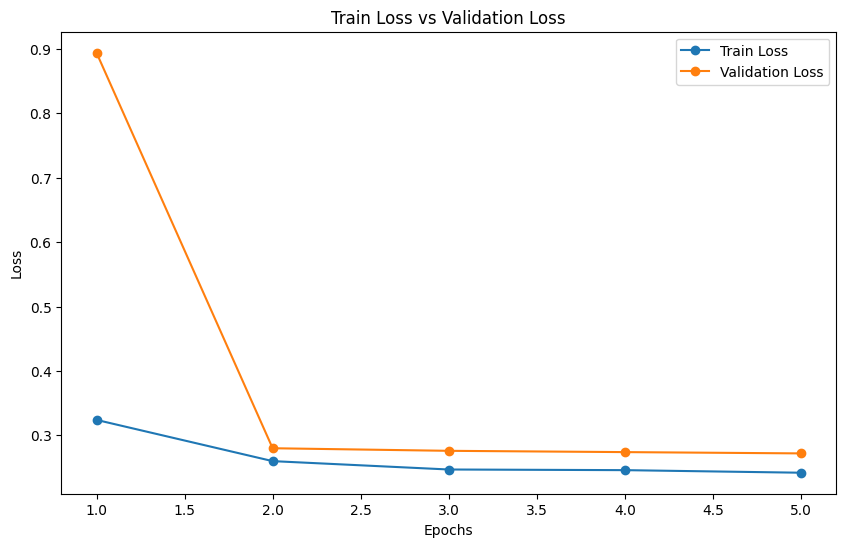

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.legend()
plt.show()

# **RoBERTa**

Setup

In [ ]:
rob_wsd_dm = WSDDataModule(
    coarse_data_train_path = coarse_train_path,
    coarse_data_dev_path = coarse_dev_path,
    coarse_data_test_path = coarse_test_path,
    fine_data_train_path = fine_train_path,
    fine_data_dev_path = fine_dev_path,
    fine_data_test_path = fine_test_path,
    train_candidate_vocab = train_candidate_vocab,
    train_pos_vocab = train_pos_vocab,
    MAX_LEN = 300,
    coarse_or_fine = 'coarse',
    num_senses = num_senses,
    tok = 'roberta',
    batch_size=32
)

In [ ]:
class HParams():
    dropout = 0.2
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    trans_model = 'roberta'
    is_freeze = True
    lr = 0.001#0.0001 #e-5
    num_candidates = num_candidates
    use_pos_embeddings = True
rob_hpar = HParams()

In [ ]:
rob_model = MyModel(rob_hpar)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
r_trainer = pl.Trainer(
    max_epochs=5,
    logger=[csv_logger],
    callbacks=[early_stopping,check_point_callback],

)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Fit

In [ ]:
r_trainer.fit(model=rob_model, datamodule=rob_wsd_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type         | Params
---------------------------------------------
0 | trans_model | RobertaModel | 124 M 
1 | dropout     | Dropout      | 0     
2 | classifier  | Linear       | 1.6 M 
---------------------------------------------
22.9 M    Trainable params
103 M     Non-trainable params
126 M     Total params
505.021   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

<ipython-input-18-d0363e481dfb>:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(embeddings, dtype=torch.float32)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.883
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 623: 'val_acc' reached 0.88258 (best 0.88258), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=0-val_f1=0.0000-v2.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.010 >= min_delta = 0.0. New best score: 0.893
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1246: 'val_acc' reached 0.89299 (best 0.89299), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=1-val_f1=0.0000-v1.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1869: 'val_acc' reached 0.87973 (best 0.89299), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=2-val_f1=0.0000-v1.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 2492: 'val_acc' reached 0.88163 (best 0.89299), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=3-val_f1=0.0000.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 3 records. Best score: 0.893. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 3115: 'val_acc' reached 0.88920 (best 0.89299), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=4-val_f1=0.0000-v1.ckpt' as top 3
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Test

In [ ]:
r_trainer.test(model=rob_model, datamodule=rob_wsd_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8915441036224365     │
│      test_loss_epoch      │    0.3504360616207123     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.3504360616207123, 'test_acc': 0.8915441036224365}]

# **Lemmas**

Setup

In [ ]:
lemmas_wsd_dm = WSDDataModule(
    coarse_data_train_path = coarse_train_path,
    coarse_data_dev_path = coarse_dev_path,
    coarse_data_test_path = coarse_test_path,
    fine_data_train_path = fine_train_path,
    fine_data_dev_path = fine_dev_path,
    fine_data_test_path = fine_test_path,
    train_candidate_vocab = train_candidate_vocab,
    train_pos_vocab = train_pos_vocab,
    MAX_LEN = 300,
    coarse_or_fine = 'coarse',
    num_senses = num_senses,
    tok = 'bert',
    batch_size=32,
    use_lemmas = True
)

In [ ]:
class HParams():
    dropout = 0.2
    tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
    trans_model = 'bert'
    is_freeze = True
    lr = 0.001#0.0001 #2e-5
    num_candidates = num_candidates
    use_pos_embeddings = True
lemmas_hpar = HParams()

In [ ]:
lemmas_model = MyModel(lemmas_hpar)

In [ ]:
l_trainer = pl.Trainer(
    max_epochs=5,
    logger=[csv_logger],
    callbacks=[early_stopping,check_point_callback],

)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Fit

In [ ]:
l_trainer.fit(model=lemmas_model, datamodule=lemmas_wsd_dm)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/Colab Notebooks a00/NLP exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type      | Params
------------------------------------------
0 | trans_model | BertModel | 108 M 
1 | dropout     | Dropout   | 0     
2 | classifier  | Linear    | 1.6 M 
------------------------------------------
22.9 M    Trainable params
87.0 M    Non-trainable params
109 M     Total params
439.679   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

<ipython-input-19-d0363e481dfb>:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(embeddings, dtype=torch.float32)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.888
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 623: 'val_acc' reached 0.88826 (best 0.88826), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=0-val_f1=0.0000-v3.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1246: 'val_acc' reached 0.87973 (best 0.88826), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=1-val_f1=0.0000-v2.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1869: 'val_acc' reached 0.88258 (best 0.88826), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=2-val_f1=0.0000-v1.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.891
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 2492: 'val_acc' reached 0.89110 (best 0.89110), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=3-val_f1=0.0000.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 3115: 'val_acc' reached 0.89015 (best 0.89110), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=4-val_f1=0.0000-v2.ckpt' as top 3
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Test

In [ ]:
l_trainer.test(model=lemmas_model, datamodule=lemmas_wsd_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8878676295280457     │
│      test_loss_epoch      │    0.3322846293449402     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.3322846293449402, 'test_acc': 0.8878676295280457}]

# **Fine candidates**

In [ ]:
train_fine_dataset = WSDDataset(coarse_file_path = coarse_train_path,fine_file_path=fine_train_path,is_train = True, MAX_LEN = 300,coarse_or_fine = 'fine',tok ='bert',use_lemmas = True)

As it is possible to see, the fine_grained senses are much more than the coarse one. This is because they are more specific and often a sense can be considered as many times as its subcategories

In [ ]:
print(train_fine_dataset.how_many_candidates())

4208


In [ ]:
train_fine_candidate_vocab = train_fine_dataset.get_train_vocab()
num_candidates = len(train_fine_candidate_vocab)
print(train_fine_candidate_vocab)

{'UNK': 0, 'nautical_mile.n.02': 1, 'mile.n.07': 2, 'nautical_mile.n.01': 3, 'mile.n.01': 4, 'united_states.n.01': 5, 'stay.v.04': 6, 'persist.v.03': 7, 'stay.v.06': 8, 'last_out.v.01': 9, 'stay.v.09': 10, 'stay.v.05': 11, 'quell.v.02': 12, 'stay.v.02': 13, 'bide.v.01': 14, 'stay.v.10': 15, 'stay.v.01': 16, 'student.n.01': 17, 'sound.v.06': 18, 'sound.v.04': 19, 'sound.v.02': 20, 'sound.v.01': 21, 'voice.v.02': 22, 'fathom.v.02': 23, 'sound.v.03': 24, 'musician.n.01': 25, 'land.n.02': 26, 'soil.n.02': 27, 'territory.n.03': 28, 'dirt.n.02': 29, 'edge.n.01': 30, 'boundary.n.02': 31, 'mass.n.08': 32, 'mass.n.05': 33, 'batch.n.02': 34, 'bulk.n.02': 35, 'mass.n.09': 36, 'mass.n.01': 37, 'multitude.n.03': 38, 'mass.n.03': 39, 'mass.n.04': 40, 'aid.n.02': 41, 'aid.n.01': 42, 'aid.n.03': 43, 'care.n.01': 44, 'seam.n.03': 45, 'bed.n.08': 46, 'bed.n.02': 47, 'bed.n.07': 48, 'layer.n.01': 49, 'bed.n.03': 50, 'bed.n.01': 51, 'bed.n.04': 52, 'airplane.n.01': 53, 'plane.n.03': 54, 'plane.n.02': 55, 

In [ ]:
train_fine_pos_vocab = train_fine_dataset.get_pos_vocab()
print(train_fine_pos_vocab,len(train_fine_pos_vocab))

{'NOUN': 0, '.': 1, 'ADP': 2, 'VERB': 3, 'NUM': 4, 'PRT': 5, 'DET': 6, 'CONJ': 7, 'ADV': 8, 'ADJ': 9, 'PRON': 10, 'X': 11} 12


In [ ]:
fine_wsd_dm = WSDDataModule(
    coarse_data_train_path = coarse_train_path,
    coarse_data_dev_path = coarse_dev_path,
    coarse_data_test_path = coarse_test_path,
    fine_data_train_path = fine_train_path,
    fine_data_dev_path = fine_dev_path,
    fine_data_test_path = fine_test_path,
    train_candidate_vocab = train_fine_candidate_vocab,
    train_pos_vocab = train_fine_pos_vocab,
    MAX_LEN = 300,
    coarse_or_fine = 'fine',
    num_senses = num_candidates,
    tok = 'bert',
    batch_size=32,
    use_lemmas = True
)


In [ ]:
class HParams():
    dropout = 0.2
    tokenizer = BertTokenizer.from_pretrained("bert-base-cased")#
    trans_model = 'bert'
    is_freeze = True
    lr = 0.001#0.0001 #2e-5
    num_candidates = num_candidates
    use_pos_embeddings = True
fine_hpar = HParams()
print(fine_hpar.num_candidates)

4208


In [ ]:
fine_model = MyModel(fine_hpar)

In [ ]:
fine_trainer = pl.Trainer(
    max_epochs=5,
    logger=[csv_logger],#wandb_logger,#logger,
    callbacks=[early_stopping,check_point_callback],

)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Fit

In [ ]:
fine_trainer.fit(model=fine_model, datamodule=fine_wsd_dm)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/Colab Notebooks a00/NLP exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type      | Params
------------------------------------------
0 | trans_model | BertModel | 108 M 
1 | dropout     | Dropout   | 0     
2 | classifier  | Linear    | 3.2 M 
------------------------------------------
24.5 M    Trainable params
87.0 M    Non-trainable params
111 M     Total params
446.185   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.709
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 623: 'val_acc' reached 0.70928 (best 0.70928), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=0-val_f1=0.0000.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.038 >= min_delta = 0.0. New best score: 0.747
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1246: 'val_acc' reached 0.74716 (best 0.74716), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=1-val_f1=0.0000.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1869: 'val_acc' reached 0.73674 (best 0.74716), saving model to '/content/drive/MyDrive/Colab Notebooks a00/NLP/epoch=2-val_f1=0.0000.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 2 records. Best score: 0.747. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 2492: 'val_acc' was not in top 3


Test

In [ ]:
fine_trainer.test(model=fine_model, datamodule=fine_wsd_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7573529481887817     │
│      test_loss_epoch      │    0.7476479411125183     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.7476479411125183, 'test_acc': 0.7573529481887817}]

# **Failed attempt**
in the first attempt I did not use a mask for candidates, also I made a label for each word in the sentence, 0 if the word was not to disambiguate, an integer corresponding to the correct sense otherwise. Obviously this approach was completely wrong and I got less than 1% accuracy

In [ ]:
class MyBrokenModel(pl.LightningModule):
  """
  The only parameter was the total number of senses
  """
    def __init__(self, num_senses):
        super(MyModel, self).__init__()
        # self.device=device
        self.bert = BertModel.from_pretrained("bert-base-cased")
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(self.bert.config.hidden_size, num_senses)

        self.f1_micro = F1Score(task = 'multiclass',num_classes = 1415)

    def forward(self, input):
        outputs = self.bert(input["input_ids"], attention_mask=input["attention_mask"], token_type_ids=input["token_type_ids"], output_hidden_states=True)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.linear(pooled_output)

        return logits

    def training_step(self, batch, batch_idx):
        input=batch['inputs'].to(device)
        labels = batch['labels']
        labels = torch.tensor(labels).to(device)
        labels = torch.argmax(labels, dim=1)
        logits = self(input)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits, labels)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        input=batch['inputs'].to(device)
        labels = batch['labels']
        labels = torch.tensor(labels).to(device)
        labels = torch.argmax(labels, dim=1)
        logits = self(input)


        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits, labels)
        self.log("val_loss", loss)

        preds = torch.argmax(logits, dim=1)
        accuracy = (preds == labels).sum().item() / labels.size(0)
        self.log("val_accuracy", accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        input=batch['inputs']
        labels = batch['labels']
        labels = torch.tensor(labels)
        logits = self(input)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits, labels)

        preds = torch.argmax(logits, dim=1)
        accuracy = (preds == labels).sum().item() / labels.size(0)
        self.log("test_accuracy", accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)
        return optimizer